# Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [1]:
#do the data things!
import numpy as np
import pandas as pd

#visualize
import matplotlib.pyplot as plt
import seaborn as sns

#my sql creds
import env

from sqlalchemy import text, create_engine

In [2]:
def get_logs():
    url=env.get_db_url('logs')
    conn=create_engine(url).connect()
    query=text('select * from api_access')
    df=pd.read_sql(query,conn)
    return df

In [3]:
df=get_logs()

In [4]:
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).strip('"')
    return pd.Series(output)

In [5]:
df=df.entry.apply(parse_log_entry)

In [6]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", 
     '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", 
     '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", 
     '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", 
     '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

In [7]:
df = pd.concat([df,new])
df=df.reset_index(drop=True)
df['size_mb']=df['size']/1024/1024
df=df.drop(columns=['size'])

In [8]:
df

,ip,timestamp,request_method,request_path,http_version,status_code,user_agent,size_mb
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,python-requests/2.21.0,0.488753
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,python-requests/2.21.0,0.003396
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,python-requests/2.21.0,0.486472
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,python-requests/2.21.0,0.486377
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,python-requests/2.21.0,0.488246
...,...,...,...,...,...,...,...,...
13973,97.105.19.58,17/Apr/2019 12:55:14,GET,/api/v1/sales?page=71,HTTP/1.1,200,python-requests/2.21.0,0.486532
13974,95.31.18.119,21/Apr/2019 10:02:41,GET,/api/v1/items/,HTTP/1.1,200,python-requests/2.21.0,1.099591
13975,95.31.16.121,17/Apr/2019 19:36:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,python-requests/2.21.0,0.000958
13976,97.105.15.120,18/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,python-requests/2.21.0,0.002441


# Detecting Anomalies:
- count
- frequency
- visualize
- conditional probability

In [9]:
df1=df.ip.value_counts().reset_index().rename(columns={'index':'ip','ip':'cnt'})
df1

,ip,cnt
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,68.201.219.223,21
5,24.26.242.9,21
6,35.175.171.137,2
7,52.87.230.102,2
8,70.121.214.34,2
9,52.90.165.200,1


### Count of how many times the request_methods shows

In [10]:
df2=df.request_method.value_counts().reset_index().rename(columns={'index':'request','request_method':'cnt'})
df2

,request,cnt
0,GET,13978


### Count of how many times the user agente shows

In [11]:
df3=df.user_agent.value_counts().reset_index().rename(columns={'index':'user_agent','user_agent':'cnt'})
df3

,user_agent,cnt
0,python-requests/2.21.0,12005
1,python-requests/2.20.1,1911
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7
5,Slackbot 1.0 (+https://api.slack.com/robots),6
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2
8,Python-urllib/3.7,1


### Frequency of each user agent

In [12]:
df.user_agent.value_counts(normalize=True)

python-requests/2.21.0                                                                                                       0.858850
python-requests/2.20.1                                                                                                       0.136715
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    0.002432
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                           0.000572
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                   0.000501
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                 0.000429
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    0.000286
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/53

In [13]:
df4=df.user_agent.value_counts(normalize=True).reset_index().rename(columns={'index':'user_agent','user_agent':'percent'})
df4

,user_agent,percent
0,python-requests/2.21.0,0.858850
1,python-requests/2.20.1,0.136715
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000143
8,Python-urllib/3.7,0.000072


In [14]:
usera_df=pd.merge(df3,df4,how='inner',on='user_agent')

In [15]:
usera_df

,user_agent,cnt,percent
0,python-requests/2.21.0,12005,0.858850
1,python-requests/2.20.1,1911,0.136715
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


### Viz

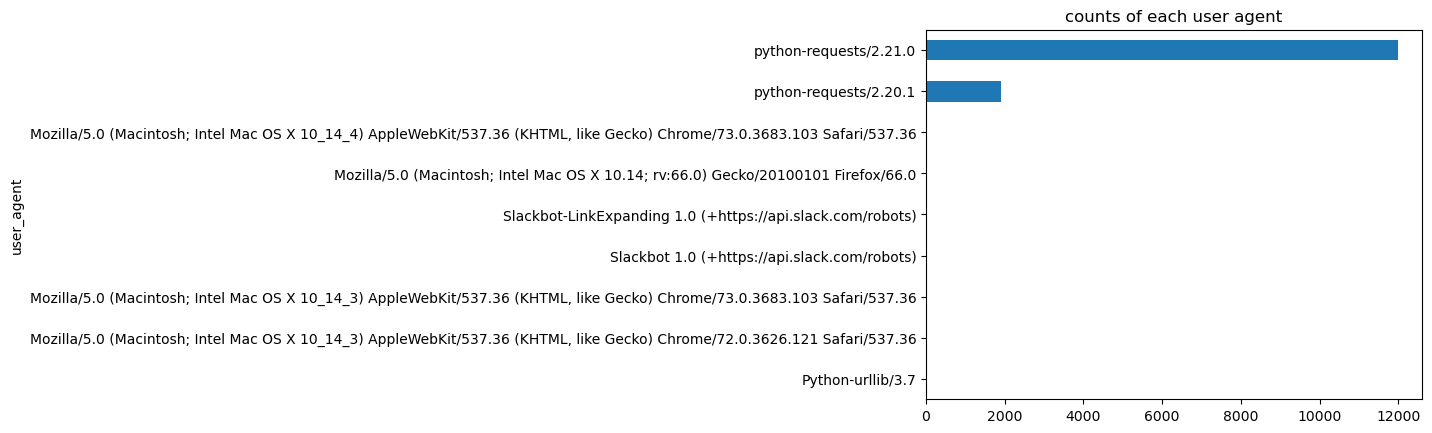

In [16]:
usera_df.set_index('user_agent').cnt.sort_values().plot.barh()
plt.title('counts of each user agent')
plt.show()

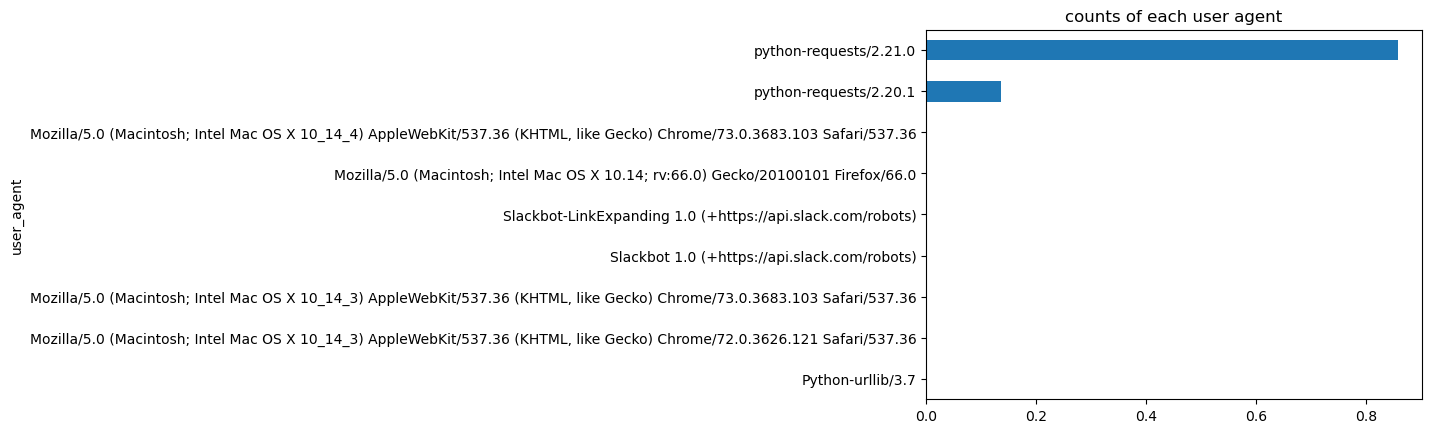

In [17]:
usera_df.set_index('user_agent').percent.sort_values().plot.barh()
plt.title('counts of each user agent')
plt.show()

### Probability

In [18]:
#probability of ip and status code
p_user=df.groupby(['user_agent']).size()/len(df)
p_user

user_agent
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                           0.000572
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36    0.000143
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    0.000286
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    0.002432
Python-urllib/3.7                                                                                                            0.000072
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                 0.000429
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                   0.000501
python-requests/2.20.1                             

In [19]:
p_size=df.groupby(['size_mb']).size()/len(df)
p_size

size_mb
0.000000    0.001145
0.000040    0.007655
0.000046    0.000215
0.000120    0.000072
0.000154    0.004936
              ...   
0.489460    0.004221
0.489533    0.004579
0.489937    0.004650
1.099591    0.000072
1.961066    0.000072
Length: 191, dtype: float64

In [20]:
p_user/p_size

Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                          NaN
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36   NaN
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36   NaN
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36   NaN
Python-urllib/3.7                                                                                                           NaN
                                                                                                                             ..
0.4894599914550781                                                                                                          NaN
0.4895334243774414                                                                                      

In [21]:
df4=df.groupby('user_agent').size_mb.value_counts(normalize=True).rename('prob').reset_index()
df4.head()

,user_agent,size_mb,prob
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.471025,0.250
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000040,0.125
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000046,0.125
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000332,0.125
4,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.001266,0.125


In [22]:
df4[df4.prob<1]

,user_agent,size_mb,prob
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.471025,0.250000
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000040,0.125000
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000046,0.125000
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000332,0.125000
4,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.001266,0.125000
...,...,...,...
387,python-requests/2.21.0,0.327981,0.000083
388,python-requests/2.21.0,0.343606,0.000083
389,python-requests/2.21.0,0.390481,0.000083
390,python-requests/2.21.0,1.099591,0.000083


In [23]:
df4[df4.prob==1]

,user_agent,size_mb,prob
17,Python-urllib/3.7,0.000154,1.0
18,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,1.0


In [24]:
df4[df4.prob==.50]

,user_agent,size_mb,prob
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000040,0.5
8,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000154,0.5
9,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000040,0.5
10,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000154,0.5


### Count of each timestamp

In [25]:
df6=df.timestamp.value_counts().reset_index().rename(columns={'index':'timestamp','timestamp':'cnt'})
df6

,timestamp,cnt
0,16/Apr/2019 19:56:10,9
1,16/Apr/2019 19:49:58,8
2,16/Apr/2019 20:01:30,7
3,16/Apr/2019 20:12:23,6
4,16/Apr/2019 20:02:59,6
...,...,...
9952,16/Apr/2019 21:10:11,1
9953,16/Apr/2019 21:10:09,1
9954,16/Apr/2019 21:10:07,1
9955,16/Apr/2019 21:10:05,1


### Frequency of each timestamp

In [26]:
df7=df.timestamp.value_counts(normalize=True).reset_index().rename(columns={'index':'timestamp','timestamp':'percent'})
df7

,timestamp,percent
0,16/Apr/2019 19:56:10,0.000644
1,16/Apr/2019 19:49:58,0.000572
2,16/Apr/2019 20:01:30,0.000501
3,16/Apr/2019 20:12:23,0.000429
4,16/Apr/2019 20:02:59,0.000429
...,...,...
9952,16/Apr/2019 21:10:11,0.000072
9953,16/Apr/2019 21:10:09,0.000072
9954,16/Apr/2019 21:10:07,0.000072
9955,16/Apr/2019 21:10:05,0.000072


In [27]:
time_df=pd.merge(df6,df7,how='inner',on='timestamp')

### Probability

In [29]:
p_time=df.groupby(['timestamp']).size()/len(df)
p_time

timestamp
16/Apr/2019 19:34:42    0.000143
16/Apr/2019 19:34:44    0.000072
16/Apr/2019 19:34:46    0.000072
16/Apr/2019 19:34:48    0.000143
16/Apr/2019 19:34:50    0.000072
                          ...   
17/Apr/2019 12:55:14    0.000072
17/Apr/2019 19:36:41    0.000072
18/Apr/2019 19:42:41    0.000072
19/Apr/2019 19:42:41    0.000072
21/Apr/2019 10:02:41    0.000072
Length: 9957, dtype: float64

In [30]:
p_size=df.groupby(['size_mb']).size()/len(df)
p_size

size_mb
0.000000    0.001145
0.000040    0.007655
0.000046    0.000215
0.000120    0.000072
0.000154    0.004936
              ...   
0.489460    0.004221
0.489533    0.004579
0.489937    0.004650
1.099591    0.000072
1.961066    0.000072
Length: 191, dtype: float64

In [31]:
p_user/p_size

Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                          NaN
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36   NaN
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36   NaN
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36   NaN
Python-urllib/3.7                                                                                                           NaN
                                                                                                                             ..
0.4894599914550781                                                                                                          NaN
0.4895334243774414                                                                                      

In [32]:
df8=df.groupby('timestamp').size_mb.value_counts(normalize=True).rename('prob').reset_index()
df8.head()

,timestamp,size_mb,prob
0,16/Apr/2019 19:34:42,0.003396,0.5
1,16/Apr/2019 19:34:42,0.488753,0.5
2,16/Apr/2019 19:34:44,0.486472,1.0
3,16/Apr/2019 19:34:46,0.486377,1.0
4,16/Apr/2019 19:34:48,0.001266,0.5


In [33]:
df8.prob.value_counts()

1.000000    6777
0.500000    5147
0.333333    1328
0.250000     397
0.200000     151
0.666667      36
0.166667      17
0.400000       9
0.125000       6
0.111111       5
0.142857       5
0.222222       2
0.600000       2
0.285714       1
Name: prob, dtype: int64

In [34]:
df8[df8.prob<1]

,timestamp,size_mb,prob
0,16/Apr/2019 19:34:42,0.003396,0.500000
1,16/Apr/2019 19:34:42,0.488753,0.500000
4,16/Apr/2019 19:34:48,0.001266,0.500000
5,16/Apr/2019 19:34:48,0.488246,0.500000
7,16/Apr/2019 19:34:52,0.000040,0.500000
...,...,...,...
13873,17/Apr/2019 12:55:09,0.489533,0.333333
13874,17/Apr/2019 12:55:12,0.487519,0.500000
13875,17/Apr/2019 12:55:12,0.487846,0.500000
13876,17/Apr/2019 12:55:13,0.486504,0.500000


In [35]:
df8[df8.prob==1]

,timestamp,size_mb,prob
2,16/Apr/2019 19:34:44,0.486472,1.0
3,16/Apr/2019 19:34:46,0.486377,1.0
6,16/Apr/2019 19:34:50,0.487092,1.0
14,16/Apr/2019 19:34:56,0.488729,1.0
15,16/Apr/2019 19:34:58,0.488323,1.0
...,...,...,...
13878,17/Apr/2019 12:55:14,0.486532,1.0
13879,17/Apr/2019 19:36:41,0.000958,1.0
13880,18/Apr/2019 19:42:41,0.002441,1.0
13881,19/Apr/2019 19:42:41,1.961066,1.0


In [36]:
df8[df8.prob<.50]

,timestamp,size_mb,prob
9,16/Apr/2019 19:34:53,0.001704,0.333333
10,16/Apr/2019 19:34:53,0.003396,0.333333
11,16/Apr/2019 19:34:53,0.003489,0.333333
36,16/Apr/2019 19:35:38,0.000040,0.200000
37,16/Apr/2019 19:35:38,0.001704,0.200000
...,...,...,...
13835,17/Apr/2019 12:54:33,0.483221,0.333333
13836,17/Apr/2019 12:54:33,0.483643,0.333333
13871,17/Apr/2019 12:55:09,0.486506,0.333333
13872,17/Apr/2019 12:55:09,0.487567,0.333333
